# Compare the KdV model with measured near seabed velocity

In [4]:
from soda.dataio import netcdfio
from soda.dataio.conversion import readotps

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd


In [5]:
%matplotlib notebook

In [6]:
# Load the station data
u1 = netcdfio.load_sql_ncstation('/home/suntans/Share/database/UWAOceanDynamics.sqlite','KP_150','water_u')[0]
v1 = netcdfio.load_sql_ncstation('/home/suntans/Share/database/UWAOceanDynamics.sqlite','KP_150','water_v')[0]

u2 = netcdfio.load_sql_ncstation('/home/suntans/Share/database/UWAOceanDynamics.sqlite','KP150','water_u')[0]
v2 = netcdfio.load_sql_ncstation('/home/suntans/Share/database/UWAOceanDynamics.sqlite','KP150','water_v')[0]

u = xr.concat([u1,u2], dim='time')
v = xr.concat([v1,v2], dim='time')


Querying database...
LOWER(Variable_Name) LIKE LOWER("water_u") and StationName LIKE "%KP_150%"
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP_150_0017
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP_150_0018
Querying database...
LOWER(Variable_Name) LIKE LOWER("water_v") and StationName LIKE "%KP_150%"
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP_150_0017
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP_150_0018
Querying database...
LOWER(Variable_Name) LIKE LOWER("water_u") and StationName LIKE "%KP150%"
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP150_0004
Querying database...
LOWER(Variable_Name) LIKE LOWER("water_v") and StationName LIKE "%KP150%"
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP150_0004


In [20]:
u.plot()

v.plot()
print(u1.X, u1.Y)

123.346383 -13.75895


<IPython.core.display.Javascript object>


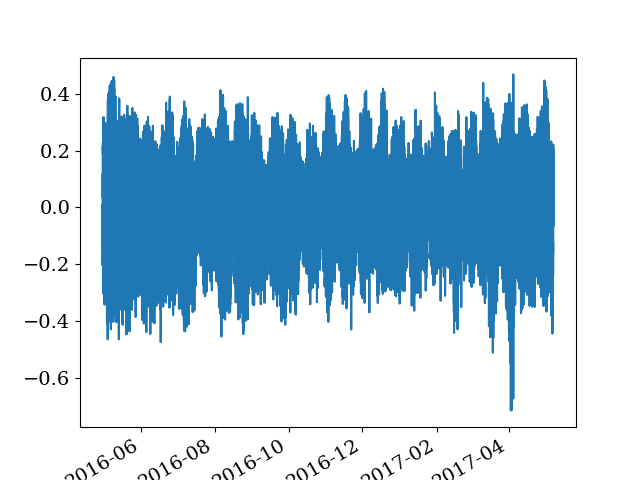

In [8]:
# Rotate the velocity +45 degrees CCW
def rotate_uv(u,v,wangle):

    ui = u+1j*v

    mag = np.abs(ui)
    ang = np.angle(ui)

    ur = mag*np.cos(ang+wangle)
    vr = mag*np.sin(ang+wangle)
    return ur,vr

wangle = 30*np.pi/180.
ur,vr = rotate_uv(u,v,wangle)
plt.figure()
ur.plot()





In [9]:
# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'

eta, ubar,vbar = readotps.tide_pred(tidemod, np.array([u1.X]), np.array([u1.Y]), u.time.values)

Interpolating consituent: M2...


/home/suntans/code/soda/dataio/conversion/readotps.py:325: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/dataio/conversion/readotps.py:325: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/dataio/conversion/readotps.py:326: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/dataio/conversion/readotps.py:326: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/dataio/conversion/readotps.py:327: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/dataio/conversion/readotps.py:327: RuntimeWarning: invalid value encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/dataio/conversion/readotps.py:328: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_im /= depth
/home/suntans/code/soda/dataio/conversion/re

Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


<IPython.core.display.Javascript object>


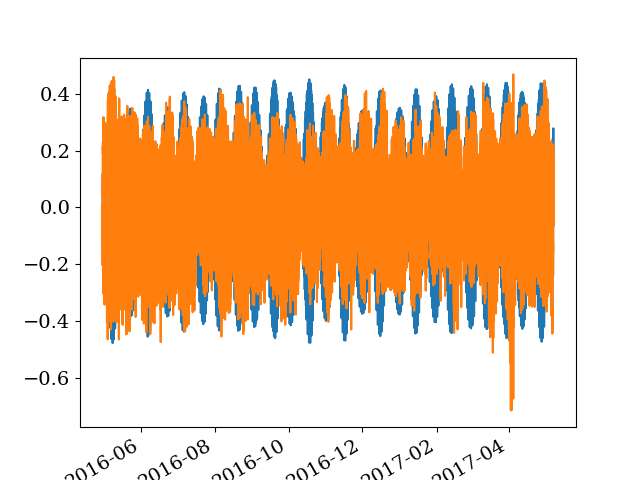

In [10]:
ubar_r, vbar_r = rotate_uv(ubar,vbar,wangle)
plt.figure()
plt.plot(u.time.values, ubar_r)
ur.plot()

<IPython.core.display.Javascript object>


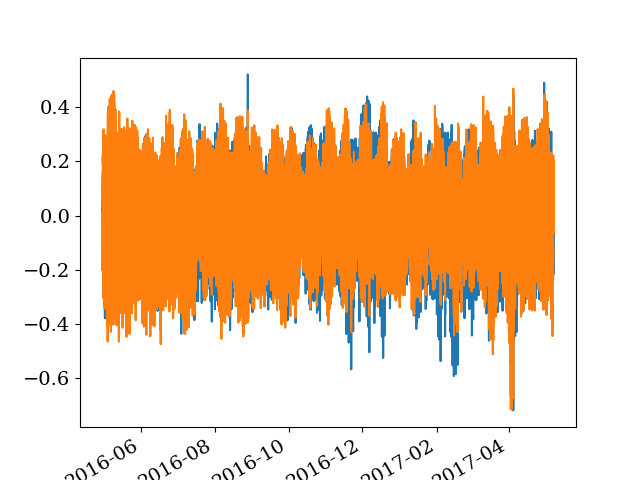

In [11]:
# Calculate the baroclinic velocity
ubc = ur.values-ubar_r.ravel()
plt.figure()
plt.plot(u.time.values,ubc)
ur.plot()

In [12]:
def maximum_amplitude_finder(amp_signal):
    amp_min = min(amp_signal)
    amp_max = max(amp_signal)
    if abs(amp_min)>amp_max:
        return amp_min
    else:
        return amp_max

In [13]:
# Convert to pandas to take rolling minmax
ubc_pd = pd.DataFrame(ubc,index=u.time.values)
ubc_pd.head()

,0
2016-04-29 23:15:00,-0.058493
2016-04-29 23:16:00,-0.050677
2016-04-29 23:17:00,-0.054539
2016-04-29 23:18:00,-0.054524
2016-04-29 23:19:00,-0.042690


<IPython.core.display.Javascript object>


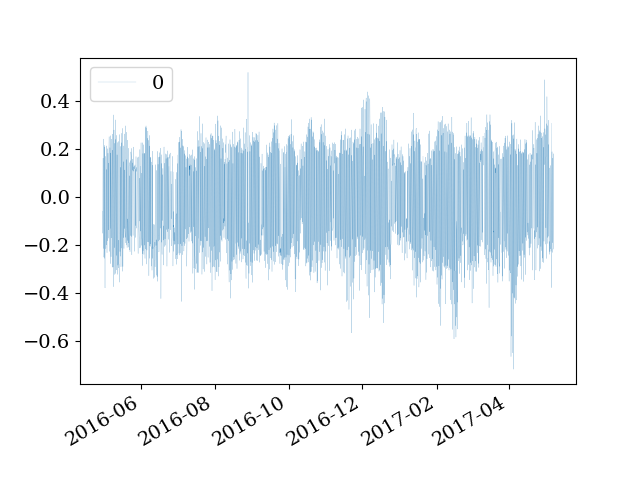

In [14]:
# Compute the maximum deviation from zero from the observations
ubc_max = ubc_pd.rolling('6H').max()
ubc_min = ubc_pd.rolling('6H').min()

idx = np.abs(ubc_min) > ubc_max
ubc_amp = ubc_max.copy()
ubc_amp[idx] = ubc_min[idx]

ubc_amp.plot(lw=0.1)

In [15]:
# Load up the kdv solution
dskdv = xr.open_dataset('../output/kdv_magnus_x100km_v2.nc')
dskdv

<xarray.Dataset>
Dimensions:   (ensemble: 500, params: 6, time: 1471)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 ... 1464 1465 1466 1467 1468 1469 1470
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params    (params) int64 0 1 2 3 4 5
Data variables:
    amax      (ensemble, time) float64 ...
    a0        (ensemble, time) float64 ...
    cn        (ensemble, time) float64 ...
    alpha     (ensemble, time) float64 ...
    beta      (time, ensemble, params) float64 ...
    ubed      (ensemble, time) float64 ...
    usurf     (ensemble, time) float64 ...

In [16]:
# Load the initial csv data to get the time
from datetime import datetime
# Load some density data

def convert_time(tt):
    try:
        dt= datetime.strptime(tt, '%Y-%m-%dT%H:%M:%S')
    except:
        dt= datetime.strptime(tt, '%Y-%m-%d %H:%M')
    return dt
def read_rho_csv(csvfile,start=0,end=-1):
    # Reads into a dataframe object
    df = pd.read_csv(csvfile, index_col=0, sep=', ', parse_dates=['Time'], date_parser=convert_time)

    depths= np.array([float(ii) for ii in df.columns.values])
    rho_obs_2d = df[start:end].values.astype(float)
    time = df.index[start:end]
    return depths, rho_obs_2d, time

   

In [17]:
 
# Shell Crux Data
csvfile1 = '../../run-ddcurves/DATA_QC/Crux_KP150_Phs1_Density_lowpass.csv'
csvfile2 = '../../run-ddcurves/DATA_QC/Crux_KP150_Phs2_Density_lowpass.csv'
zmin = -252.5
site = 'Crux'

#csvfile1
depths1, rho1, time1 = read_rho_csv(csvfile1)
depths2, rho2, time2 = read_rho_csv(csvfile2)

time = np.concatenate([time1,time2[8::]])

time.shape

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  del sys.path[0]


(1471,)

In [18]:
# Find the nearest observation to each time
uamp_xr = xr.DataArray(ubc_amp)
uamp_mapped = uamp_xr.sel(dim_0=time)

#ubc_amp_mapped = ubc_pd.select(time=time)

<IPython.core.display.Javascript object>


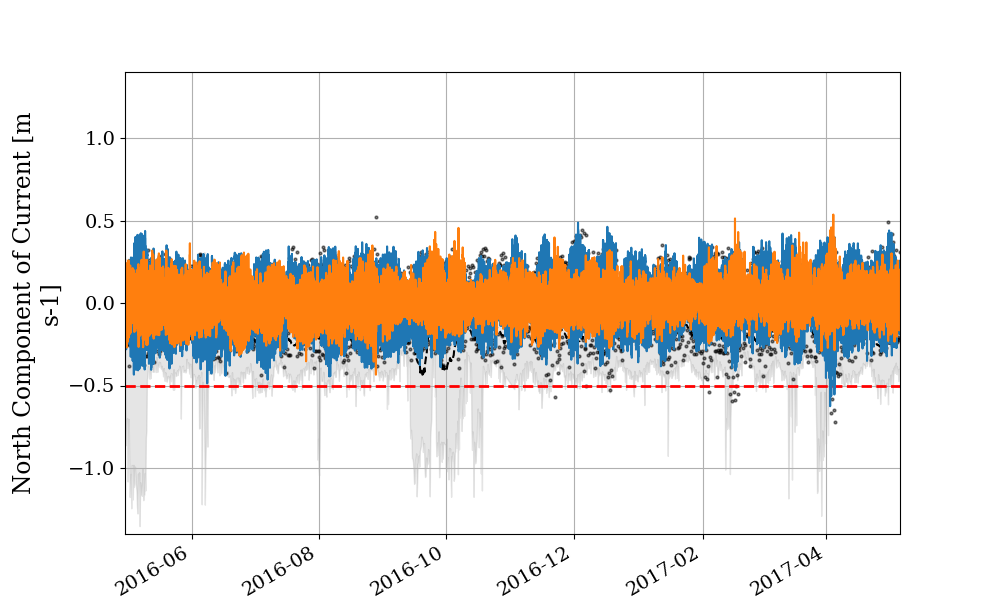

In [19]:
ubed_min = dskdv.ubed.min(axis=0)
ubed_max = dskdv.ubed.max(axis=0)
ubed_50 = np.mean(dskdv.ubed, axis=0)


usurf_min = dskdv.usurf.min(axis=0)
usurf_max = dskdv.usurf.max(axis=0)
usurf_50 = np.mean(dskdv.usurf, axis=0)

plt.figure(figsize=(10,6))
plt.subplot(111)
plt.fill_between(time, ubed_min, ubed_max, color='0.5',alpha=0.2)
plt.plot(time,ubed_50,'k--', lw=1.5)
plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
#plt.xlim(200,300)
plt.ylabel('$u_{bed}$ [m/s]')
plt.ylim(-1.4,1.4)
#plt.xlabel('time [days]')
plt.grid(b=True)
plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)

plt.xlabel('time [yyyy-mm]')
plt.grid(b=True)
plt.xlim(time[0],time[-1])
plt.savefig('../FIGURES/kdv_12month_velocity_validation.png',dpi=150)
plt.show()